In [45]:
import pandas as pd

# 确保所有列都能显示出来
pd.set_option('display.max_columns', 500)

# 确保列宽足够，不会把长字符串（比如 Method 名）截断
pd.set_option('display.max_colwidth', 100)

# 确保表格的总宽度足够，不会换行显示
pd.set_option('display.width', 1000)

In [2]:
TASK_METRIC = {
    "cola": ["eval_matthews_correlation"],
    "mnli": ["matched_accuracy", "mismatched_accuracy"],
    "mrpc": ["eval_accuracy", "eval_f1"],
    "qnli": ["eval_accuracy"],
    "qqp": ["eval_accuracy", "eval_f1"],
    "rte": ["eval_accuracy"],
    "sst2": ["eval_accuracy"],
    "stsb": ["eval_pearson", "eval_spearman"],
    "wnli": ["eval_accuracy"],
}

METRIC_NAME_MAP = {
    'eval_matthews_correlation': 'Mcc',
    'matched_accuracy': 'm',
    'mismatched_accuracy': 'mm',
    'eval_accuracy': 'Acc',
    'eval_f1': 'F1',
    'eval_pearson': 'Corr_p',
    'eval_spearman': 'Corr_s',
}

TASK_NAME_MAP = {
    'mnli': 'MNLI',
    'sst2': 'SST-2',
    'cola': 'CoLA',
    'qqp': 'QQP',
    'qnli': 'QNLI',
    'rte': 'RTE',
    'mrpc': 'MRPC',
    'stsb': 'STS-B',
}

FAMILY_NAME_MAP = {
    'bert': 'BERT-b',
    'roberta': 'RoB-b',
    'deberta': 'DeB-b',
}

METHOD_NAME_MAP = {
    'lora': 'LoRA',
    'olora': 'OLoRA',
    'dora': 'DoRA',
    'mrlora': 'MR-LoRA',
    'adalora': 'AdaLoRA',
    'mrlora-rs': 'MR-LoRA-RS',
    'rslora': 'RS-LoRA'
}
VARIANT_NAME_MAP = {
    'fft': 'FFT',
    'lora': 'LoRA-Finetuning',
    'kd-lora': 'KD-LoRA-Finetuning'
}

REMOVE_PEFT = ['mrlora-rs']

In [16]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import  NA

def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./ablation').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    # for mnli, need patching.
    if 'eval_runtime' in data:
        eval_runtime = data.get('eval_runtime')
    else:
        eval_runtime_history = []
        for item in data['log_history']:
            if 'eval_runtime' in item:
                eval_runtime_history.append(item['eval_runtime'])
        eval_runtime = sum(eval_runtime_history) / len(eval_runtime_history)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', NA)
    train_runtime = dictor(data, 'train.train_time', NA)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else NA

    rank = dictor(data, 'args.rank')

    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:
        if key in data:
            accuracy = data[key]
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "value": round(accuracy, 4),
                "metric": key,
                "params": round(trainable_params, 4),
                "traintime": round(train_runtime, 2),
                "evaltime": round(eval_runtime, 2),
                "gpumem": round(avg_memory, 2),
                "rank": rank, # total rank.
                'seed': dictor(data, 'args.seed'),
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    return final_df

df = aggregate_experiment_results('./ablation/')

In [5]:
df.family.unique()

array(['roberta'], dtype=object)

In [6]:
df.peft.unique()

array(['mrlora-olora-lcoef-bias', 'mrlora-lcoef-bias',
       'mrlora-olora-bias', 'mrlora', 'mrlora-rs-bias',
       'mrlora-olora-rs-bias', 'mrlora-olora-lcoef', 'mrlora-rs-lcoef',
       'mrlora-rs-lcoef-bias', 'mrlora-olora-rs',
       'mrlora-olora-rs-lcoef-bias', 'mrlora-rs', 'mrlora-lcoef',
       'mrlora-bias', 'mrlora-olora', 'mrlora-olora-rs-lcoef'],
      dtype=object)

In [14]:
df['rank'].unique()

array([8])

In [7]:
df.task.unique()

array(['mrpc', 'rte', 'qqp', 'qnli'], dtype=object)

In [18]:
df.groupby('task').count()

,family,peft,variant,value,metric,params,traintime,evaltime,gpumem,rank,seed
task,,,,,,,,,,,
mrpc,32,32,32,32,32,32,32,32,32,32,32
qnli,16,16,16,16,16,16,16,16,16,16,16
qqp,32,32,32,32,32,32,32,32,32,32,32
rte,16,16,16,16,16,16,16,16,16,16,16


In [9]:
df.metric.unique()

array(['eval_accuracy', 'eval_f1'], dtype=object)

In [10]:
df.seed.unique()

array([42])

In [17]:
df.variant.unique()

array(['lora'], dtype=object)

In [20]:
df.params.unique()

array([0.5922, 0.5921])

In [24]:
df_simple = df.drop(columns=['seed', 'family', 'params', 'rank', 'variant'])

In [28]:
import pandas as pd
import seaborn as sns

# 1. Expand the 'peft' strings into feature columns
features = ['olora', 'rs', 'bias', 'lcoef']

for f in features:
    # Checks if the feature name exists as a standalone word in the string
    df_simple[f] = df_simple['peft'].apply(lambda x: f in x.split('-'))

# 2. Create a Pivot Table
# We group by the feature flags and show the mean 'value' for each 'task'
pivot_df = df_simple.pivot_table(
    index=features,
    columns='task',
    values='value',
    aggfunc='mean'
)

# 3. Apply Styling (Conditional Formatting)
styled_table = pivot_df.style.background_gradient(axis=0, cmap='YlGnBu') \
                             .format("{:.4f}") \
                             .set_caption("MrLoRA Feature Ablation Study")

# Display in Jupyter/Colab
styled_table

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of features to isolate
features = ['olora', 'rs', 'bias', 'lcoef']

# Create boolean columns: True if feature name is in the 'peft' string
for f in features:
    df_simple[f] = df_simple['peft'].apply(lambda x: f in x.split('-'))

In [30]:
impact_results = []

for f in features:
    # Calculate Mean for 'On' vs 'Off' across all tasks
    summary = df_simple.groupby(f)['value'].mean()
    impact_results.append({
        'Feature': f,
        'Off_Avg': summary[False],
        'On_Avg': summary[True],
        'Delta': summary[True] - summary[False]
    })

df_impact = pd.DataFrame(impact_results)
print(df_impact)

  Feature   Off_Avg    On_Avg     Delta
0   olora  0.545365  0.542708 -0.002656
1      rs  0.543623  0.544450  0.000827
2    bias  0.562256  0.525817 -0.036440
3   lcoef  0.543435  0.544637  0.001202


/var/folders/82/tr0t3jp906z8k_q9pbcg_jd40000gn/T/ipykernel_21555/1925518258.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


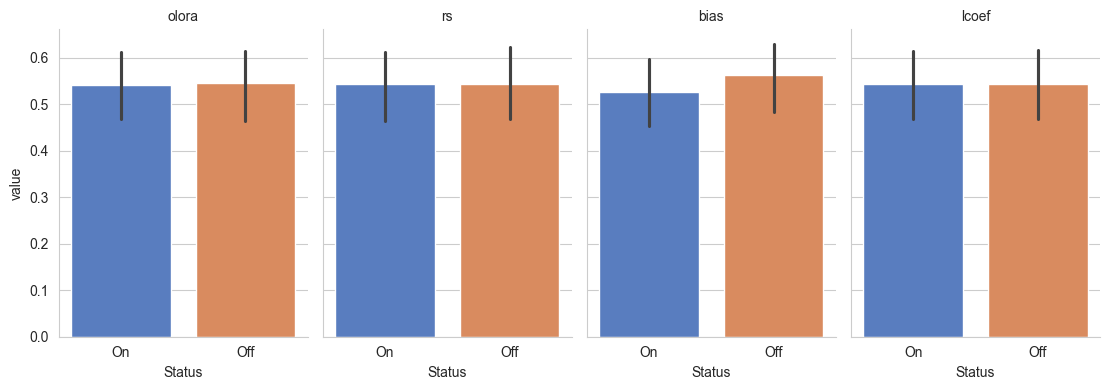

In [31]:
# Melt the data for visualization
plot_data = []
for f in features:
    subset = df_simple[[f, 'value', 'task']].copy()
    subset['Feature_Name'] = f
    subset = subset.rename(columns={f: 'Status'})
    subset['Status'] = subset['Status'].map({True: 'On', False: 'Off'})
    plot_data.append(subset)

df_plot = pd.concat(plot_data)

# Create a FacetGrid to see On/Off for each feature across tasks
g = sns.catplot(
    data=df_plot, x='Status', y='value',
    col='Feature_Name', kind='bar',
    palette='muted', height=4, aspect=0.7
)
g.set_titles("{col_name}")
